In [14]:
import os
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, cohen_kappa_score,
    roc_auc_score, average_precision_score,
    mean_squared_error
)
import math

try:
    import krippendorff
    KRIPP_AVAILABLE = True
except ImportError:
    KRIPP_AVAILABLE = False

# Local dataset paths
IMG_DIR = r"C:\Users\USAMA\Downloads\Assignments\Deep\images"
ANN_DIR = r"C:\Users\USAMA\Downloads\Assignments\Deep\annotations"

IMG_SIZE = (224, 224)

In [15]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, img_files, batch_size=32, shuffle=True, augment=False):
        self.img_files = img_files
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.img_files) / self.batch_size))
    
    def __getitem__(self, idx):
        batch_files = self.img_files[idx*self.batch_size:(idx+1)*self.batch_size]
        
        X, y_exp, y_aro, y_val = [], [], [], []
        
        for img_path in batch_files:
            base = os.path.splitext(os.path.basename(img_path))[0]
            
            # Load and resize image
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.resize(img, IMG_SIZE)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0
            
            # Data augmentation
            if self.augment:
                if np.random.rand() > 0.5:
                    img = np.fliplr(img)  # horizontal flip
                if np.random.rand() > 0.7:
                    img = np.clip(img * np.random.uniform(0.8, 1.2), 0, 1)  # brightness
                
            # Load annotations
            exp = np.load(os.path.join(ANN_DIR, f"{base}_exp.npy"))
            aro = np.load(os.path.join(ANN_DIR, f"{base}_aro.npy"))
            val = np.load(os.path.join(ANN_DIR, f"{base}_val.npy"))
            
            X.append(img)
            y_exp.append(int(exp))
            y_aro.append(float(aro))
            y_val.append(float(val))
        
        return np.array(X), {
            "expression": np.array(y_exp),
            "arousal": np.array(y_aro),
            "valence": np.array(y_val)
        }
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.img_files)

In [16]:
# Train-Test Split
all_imgs = glob.glob(os.path.join(IMG_DIR, "*.jpg"))
print("Total images:", len(all_imgs))

train_imgs, test_imgs = train_test_split(all_imgs, test_size=0.2, random_state=42)

train_gen = DataGenerator(train_imgs, batch_size=32, augment=True)
test_gen = DataGenerator(test_imgs, batch_size=32, augment=False)

Total images: 3999


In [17]:
# Build CNN Models
def build_model(base_model):
    base = base_model(weights="imagenet", include_top=False, input_shape=(224,224,3))
    x = GlobalAveragePooling2D()(base.output)

    # Branch 1: Expression Classification
    exp_out = Dense(8, activation="softmax", name="expression")(x)

    # Branch 2: Arousal Regression
    aro_out = Dense(1, activation="tanh", name="arousal")(x)

    # Branch 3: Valence Regression
    val_out = Dense(1, activation="tanh", name="valence")(x)

    model = Model(inputs=base.input, outputs=[exp_out, aro_out, val_out])

    model.compile(
        optimizer="adam",
        loss={
            "expression": "sparse_categorical_crossentropy",
            "arousal": "mse",
            "valence": "mse"
        },
        metrics={
            "expression": "accuracy",
            "arousal": "mae",
            "valence": "mae"
        }
    )
    return model

In [18]:
# Train Models
# Baseline 1: VGG16
vgg_model = build_model(VGG16)
print("\n🚀 Training VGG16 (debug mode)...")
history_vgg = vgg_model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=2,
    steps_per_epoch=1, 
    validation_steps=2
)

# Baseline 2: ResNet50
resnet_model = build_model(ResNet50)
print("\n🚀 Training ResNet50 (debug mode)...")
history_resnet = resnet_model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=2,
    steps_per_epoch=1,
    validation_steps=2
)


🚀 Training VGG16 (debug mode)...


C:\Users\USAMA\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137s/step - arousal_loss: 0.2566 - arousal_mae: 0.3874 - expression_accuracy: 0.0625 - expression_loss: 2.2369 - loss: 2.9074 - valence_loss: 0.4139 - valence_mae: 0.5188WARNING:tensorflow:5 out of the last 13 calls to <function TensorFlowTrainer._make_function.<locals>.multi_step_on_iterator at 0x000002CCE1DFD1C0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
1/1 ━━━━━━━━━━━━━━━━━━━━ 174s 174s/step - arousal_loss: 0.2566 - arousal_mae: 

In [19]:
# Evaluation Metrics
def concordance_correlation_coefficient(y_true, y_pred):
    """CCC: Concordance Correlation Coefficient"""
    mean_true, mean_pred = np.mean(y_true), np.mean(y_pred)
    var_true, var_pred = np.var(y_true), np.var(y_pred)
    cov = np.mean((y_true - mean_true) * (y_pred - mean_pred))
    ccc = (2 * cov) / (var_true + var_pred + (mean_true - mean_pred) ** 2)
    return ccc

def sign_agreement(y_true, y_pred):
    """SAGR: Sign Agreement Metric"""
    sign_true = np.sign(y_true)
    sign_pred = np.sign(y_pred)
    return np.mean(sign_true == sign_pred)

def evaluate_model(model, test_gen, name="Model", steps=5):
    y_true_exp, y_true_aro, y_true_val = [], [], []
    y_pred_exp, y_pred_proba, y_pred_aro, y_pred_val = [], [], [], []
    
    for i, (X_batch, y_batch) in enumerate(test_gen):
        if i >= steps:
            break
        preds = model.predict(X_batch, verbose=0)
        
        # Predictions
        y_pred_exp.extend(np.argmax(preds[0], axis=1))
        y_pred_proba.extend(preds[0])  # softmax probs
        y_pred_aro.extend(preds[1].flatten())
        y_pred_val.extend(preds[2].flatten())
        
        # Ground truth
        y_true_exp.extend(y_batch["expression"])
        y_true_aro.extend(y_batch["arousal"])
        y_true_val.extend(y_batch["valence"])
    
    y_true_exp = np.array(y_true_exp)
    y_pred_exp = np.array(y_pred_exp)
    y_pred_proba = np.array(y_pred_proba)
    y_true_aro = np.array(y_true_aro)
    y_pred_aro = np.array(y_pred_aro)
    y_true_val = np.array(y_true_val)
    y_pred_val = np.array(y_pred_val)
    
    print(f"\n===== {name} Evaluation =====")
    # Classification metrics
    print("Accuracy:", accuracy_score(y_true_exp, y_pred_exp))
    print("F1 Score:", f1_score(y_true_exp, y_pred_exp, average="weighted"))
    print("Cohen Kappa:", cohen_kappa_score(y_true_exp, y_pred_exp))
    
    if KRIPP_AVAILABLE:
        alpha = krippendorff.alpha(reliability_data=[y_true_exp, y_pred_exp])
        print("Krippendorff's Alpha:", alpha)
    else:
        print("Krippendorff's Alpha: (install `pip install krippendorff` to compute)")
    
    try:
        y_true_bin = tf.keras.utils.to_categorical(y_true_exp, num_classes=8)
        auc = roc_auc_score(y_true_bin, y_pred_proba, multi_class="ovr")
        auc_pr = average_precision_score(y_true_bin, y_pred_proba, average="macro")
        print("AUC (ROC):", auc)
        print("AUC-PR:", auc_pr)
    except Exception as e:
        print("AUC metrics could not be computed:", e)
    
    # Regression metrics
    rmse_aro = math.sqrt(mean_squared_error(y_true_aro, y_pred_aro))
    rmse_val = math.sqrt(mean_squared_error(y_true_val, y_pred_val))
    corr_aro = np.corrcoef(y_true_aro, y_pred_aro)[0,1]
    corr_val = np.corrcoef(y_true_val, y_pred_val)[0,1]
    sagr_aro = sign_agreement(y_true_aro, y_pred_aro)
    sagr_val = sign_agreement(y_true_val, y_pred_val)
    ccc_aro = concordance_correlation_coefficient(y_true_aro, y_pred_aro)
    ccc_val = concordance_correlation_coefficient(y_true_val, y_pred_val)

    print("RMSE (Arousal):", rmse_aro)
    print("RMSE (Valence):", rmse_val)
    print("CORR (Arousal):", corr_aro)
    print("CORR (Valence):", corr_val)
    print("SAGR (Arousal):", sagr_aro)
    print("SAGR (Valence):", sagr_val)
    print("CCC (Arousal):", ccc_aro)
    print("CCC (Valence):", ccc_val)

In [20]:
# Show Predictions
EXP_LABELS = {
    0: "Neutral", 1: "Happy", 2: "Sad", 3: "Surprise",
    4: "Fear", 5: "Disgust", 6: "Anger", 7: "Contempt"
}

def show_predictions(model, test_gen, num_samples=8):
    X_batch, y_batch = next(iter(test_gen))
    preds = model.predict(X_batch, verbose=0)

    y_true_exp = y_batch["expression"]
    y_pred_exp = np.argmax(preds[0], axis=1)
    y_pred_aro = preds[1].flatten()
    y_pred_val = preds[2].flatten()

    plt.figure(figsize=(16, 8))
    for i in range(min(num_samples, len(X_batch))):
        plt.subplot(2, 4, i+1)
        plt.imshow(X_batch[i])
        gt = EXP_LABELS[y_true_exp[i]]
        pred = EXP_LABELS[y_pred_exp[i]]
        
        color = "green" if gt == pred else "red"
        plt.title(f"GT: {gt}\nPred: {pred}\nVal:{y_pred_val[i]:.2f}, Aro:{y_pred_aro[i]:.2f}",
                  color=color, fontsize=10)
        plt.axis("off")
    plt.show()


In [21]:
# Training Graphs
def plot_history(history, title="Model Training"):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['expression_accuracy'], label='Train Acc')
    plt.plot(history.history['val_expression_accuracy'], label='Val Acc')
    plt.title(f"{title} - Expression Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f"{title} - Total Loss")
    plt.legend()
    plt.show()


===== VGG16 Evaluation =====
Accuracy: 0.13125
F1 Score: 0.030455801104972376
Cohen Kappa: 0.0
Krippendorff's Alpha: (install `pip install krippendorff` to compute)
AUC (ROC): 0.5031691218717917
AUC-PR: 0.1450263029797486
RMSE (Arousal): 0.7900017849072082
RMSE (Valence): 1.273683928255869
CORR (Arousal): 0.05522143240073499
CORR (Valence): -0.04893303013895919
SAGR (Arousal): 0.74375
SAGR (Valence): 0.29375
CCC (Arousal): 4.304855579484142e-05
CCC (Valence): -1.6575579946654078e-05

===== ResNet50 Evaluation =====
Accuracy: 0.13125
F1 Score: 0.030455801104972376
Cohen Kappa: 0.0
Krippendorff's Alpha: (install `pip install krippendorff` to compute)
AUC (ROC): 0.4967431533676121
AUC-PR: 0.14683354037283433
RMSE (Arousal): 0.7861044619978432
RMSE (Valence): 1.122298769573697
CORR (Arousal): 0.020181116980002255
CORR (Valence): 0.11836735792727393
SAGR (Arousal): 0.74375
SAGR (Valence): 0.29375
CCC (Arousal): 1.4355662903043214e-05
CCC (Valence): 0.0018003565286752463


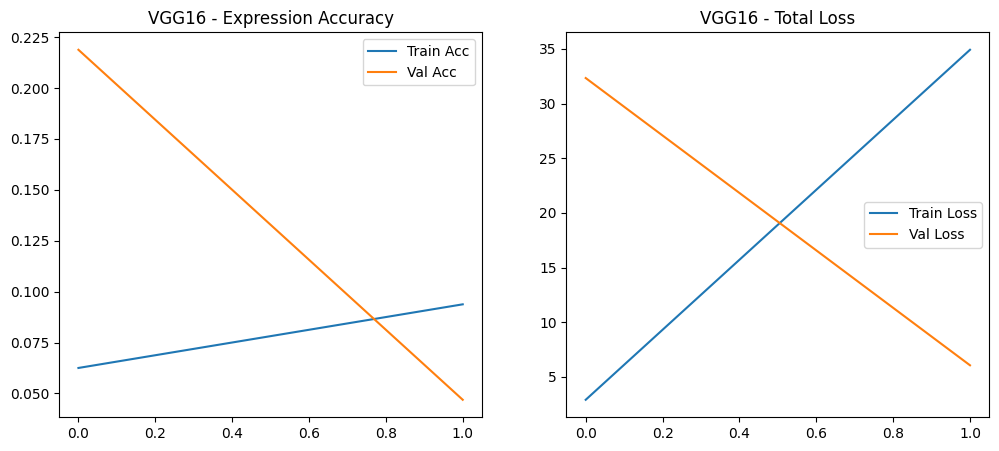

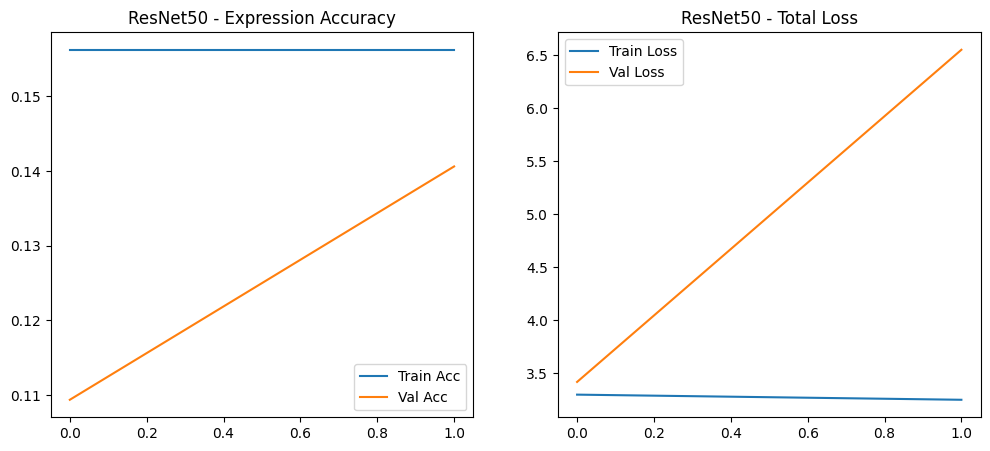

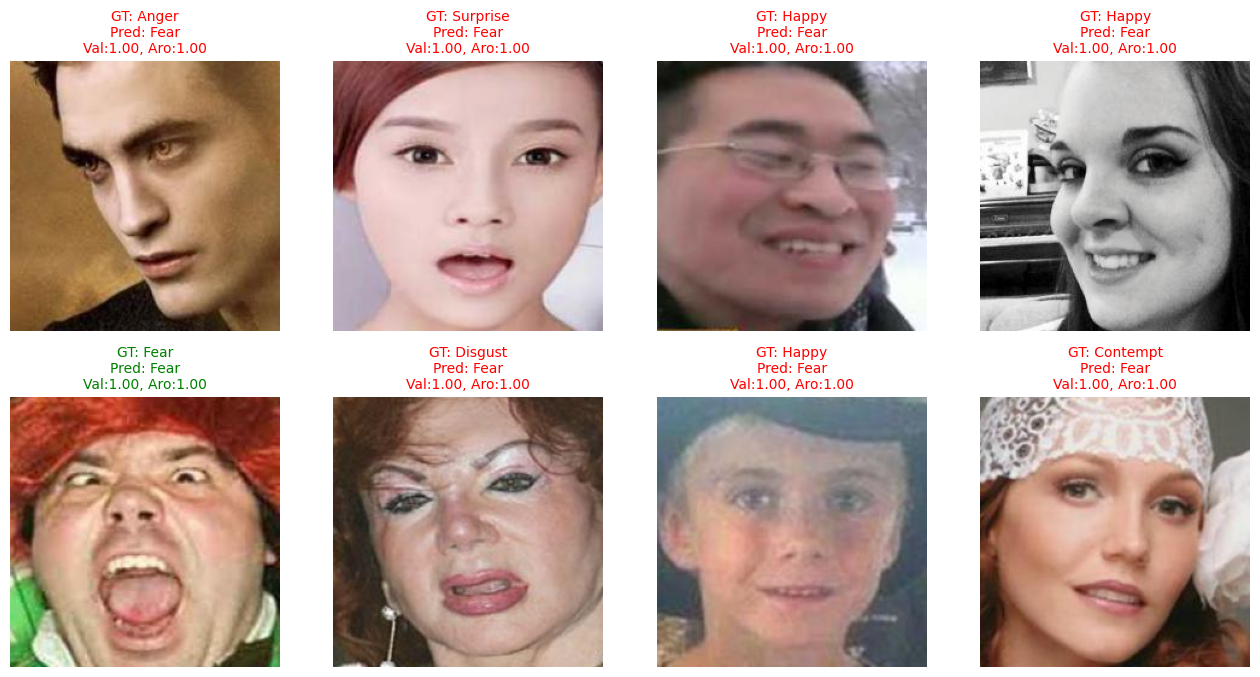

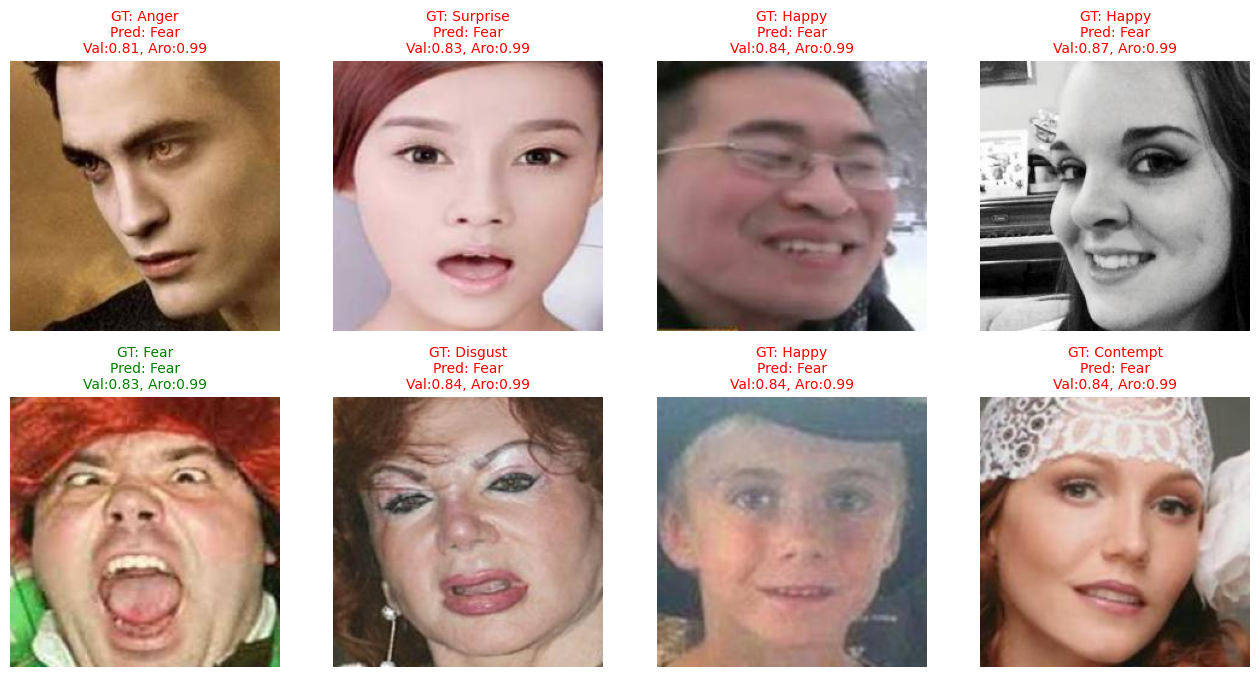

In [22]:
# Run Evaluation
evaluate_model(vgg_model, test_gen, "VGG16")
evaluate_model(resnet_model, test_gen, "ResNet50")

plot_history(history_vgg, "VGG16")
plot_history(history_resnet, "ResNet50")

show_predictions(vgg_model, test_gen, num_samples=8)
show_predictions(resnet_model, test_gen, num_samples=8)